<a href="https://colab.research.google.com/github/gibranmr/accretion/blob/main/accretion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mass fall-back accretion in the central engine of GRBs

En este código se reproducen las gráficas de acreción de masas en el motor de un GRBs. Se intenta reproducir la Figura 3 del artículo de Kumar 2008 (MNRAS,388,1729)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
from astropy import units as u
from astropy.constants import G, c, M_sun



# Keplerian angular velocities $\Omega_k$

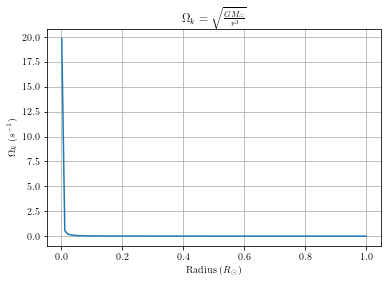

In [2]:

# For LaTeX rendering in matplotlib
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['CMU Serif']
mpl.rc('text', usetex=True)
mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.unicode'] = True  # Uncomment this if needed for older matplotlib versions
mpl.rcParams.update({'font.size': 18})

# Defining the Keplerian angular velocity function
def keplerian_angular_velocity(r):
    return np.sqrt(G * M_sun / r**3)

# Generating radius values from the center to the surface of the star (0 to 1 solar radius)
radii = np.linspace(0.001, 1, 100) * u.R_sun  # Avoiding r=0 to prevent division by zero

# Calculate angular velocities
angular_velocities = keplerian_angular_velocity(radii)

# Plotting
#plt.figure(figsize=(10, 6))
plt.plot(radii, angular_velocities.to(1/u.s))
plt.xlabel(r'Radius ($R_{\odot}$)')
plt.ylabel(r'$\Omega_k$ ($s^{-1}$)')
plt.title(r' $\Omega_k = \sqrt{\frac{G M_{\odot}}{r^3}}$ ')
plt.grid(True)
plt.show()




# Eccentricity $e$

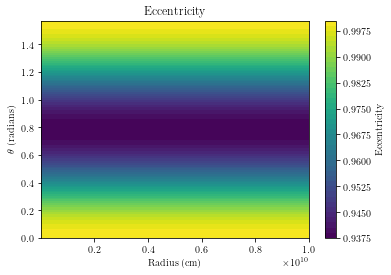

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

# Constants in cgs units
G = 6.67430e-8 * u.cm**3 / u.g / u.s**2
M_sun = 1.989 * 10**33 * u.g
M = 1 * u.M_sun




# Keplerian Angular Velocity
def Omega_k(r):
    return np.sqrt(G * M / r**3)

# Ansatz function;
def Omega(r, theta):
    return 0.5 * Omega_k(r) * np.cos(theta)

# Eccentricity function
def eccentricity(r, theta):
    return 1 - (Omega(r, theta)**2 / Omega_k(r)**2) * np.sin(theta)**2

# Grid in r and theta
r = np.linspace(1e6, 1e10, 100) * u.cm  # Some sample radii in cm
theta = np.linspace(0, np.pi/2, 100)  # Polar angle from 0 to 90 degrees
R, Theta = np.meshgrid(r, theta)

E = eccentricity(R, Theta)

# Plot
plt.figure()
cp = plt.contourf(R.value, Theta, E, 50, cmap='viridis')  # Use .value to get the numerical values for plotting
plt.colorbar(cp, label='Eccentricity')
plt.title('Eccentricity')
plt.xlabel('Radius (cm)')
plt.ylabel(r'$\theta$ (radians)')
plt.show()



# Positions

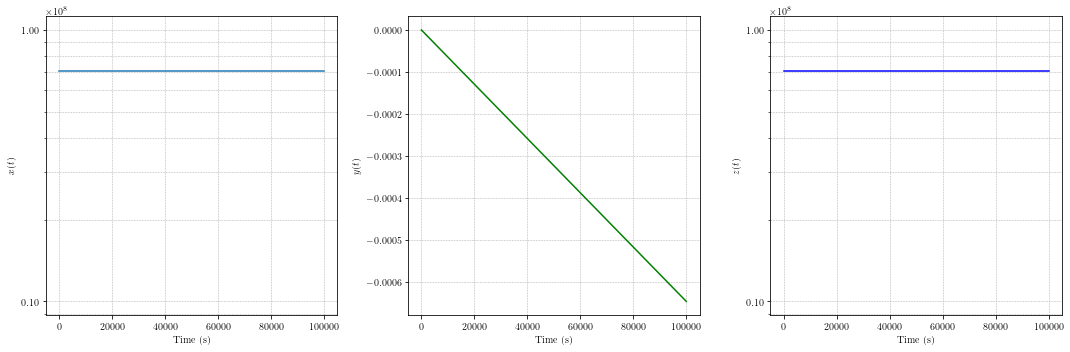

In [4]:
from scipy.optimize import newton
import matplotlib.ticker as mticker

# Given initial conditions
r_initial = 1e8 * u.cm
theta_initial = np.pi / 4
phi_initial = 0  # Example initial condition for phi
M_r_example = 16 * u.M_sun  # Example enclosed mass within r_initial in order to use Model 16T1 of Woosley



def eta_from_t(t, e, r, M_r):
    Omega_k_val = Omega_k(r).value

    # The equation relating eta to t
    def f(eta):
        return Omega_k_val * t - (eta + e * np.sin(eta)) * (1 + e)**(-1.5)

    # Numerical solver to find eta
    return newton(f, 0)

def particle_trajectory(t, r, theta, phi, e, M_r):
    Omega_k_val = Omega_k(r).value
    eta = eta_from_t(t, e, r, M_r)

    a = r / (1 + e)

    x = a * (e + np.cos(eta)) * np.sin(theta) * np.cos(phi) + a * (1 - e**2)**0.5 * np.sin(eta) * np.sin(phi)
    y = a * (e + np.cos(eta)) * np.sin(theta) * np.sin(phi) - a * (1 - e**2)**0.5 * np.sin(eta) * np.cos(phi)
    z = a * (e + np.cos(eta)) * np.cos(theta)

    return x, y, z

# The range of times for which to calculate x, y, and z
times = np.linspace(0, 1e5, 500)  # Example: from 0 to 100,000 seconds in 500 steps

e_value = eccentricity(r_initial, theta_initial).value  # No units

#Trajectories
x_vals, y_vals, z_vals = [], [], []
for t in times:
    x, y, z = particle_trajectory(t, r_initial.value, theta_initial, phi_initial, e_value, M_r_example.value)
    x_vals.append(x)
    y_vals.append(y)
    z_vals.append(z)

# Using  x_vals, y_vals, z_vals and times
plt.figure(figsize=(15, 5))


formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))

# Plot for x(t)
plt.subplot(1, 3, 1)
plt.plot(times, x_vals, label="x(t)")
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(formatter)  # Set y-axis labels to scientific notation
plt.xlabel("Time (s)")
plt.ylabel(r"$x(t)$")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot for y(t)
plt.subplot(1, 3, 2)
plt.plot(times, y_vals, color='g', label="y(t)")
plt.yscale("linear")
plt.gca().yaxis.set_major_formatter(formatter)  # Set y-axis labels to scientific notation
plt.xlabel("Time (s)")
plt.ylabel(r"$y(t)$")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot for z(t)
plt.subplot(1, 3, 3)
plt.plot(times, z_vals, color='b', label="z(t)")
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(formatter)  # Set y-axis labels to scientific notation
plt.xlabel("Time (s)")
plt.ylabel(r"$z(t)$")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Positions in a 3D-Plot

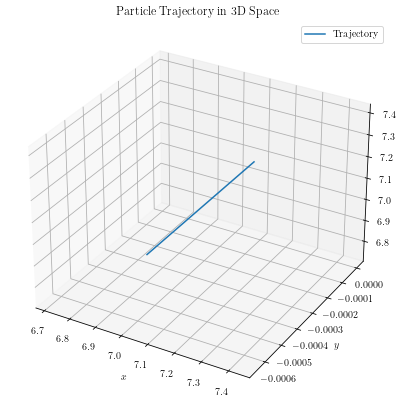

In [5]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(x_vals, y_vals, z_vals, label='Trajectory')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.set_title('Particle Trajectory in 3D Space')
ax.legend()
plt.show()

# Velocities

In [6]:
def v_x(r, theta, phi, e, M_r):
    return -r * Omega_k(r, M_r) * (np.sin(theta) * np.cos(phi) + e * np.sin(phi)) / np.sqrt(1 - e)

def v_y(r, theta, phi, e, M_r):
    return -r * Omega_k(r, M_r) * (np.sin(theta) * np.sin(phi) - e * np.cos(phi)) / np.sqrt(1 - e)

def v_z(r, theta, e, M_r, sign="+"):
    factor = 1 if sign == "+" else -1
    return factor * r * Omega_k(r, M_r) * np.cos(theta) / np.sqrt(1 - e)

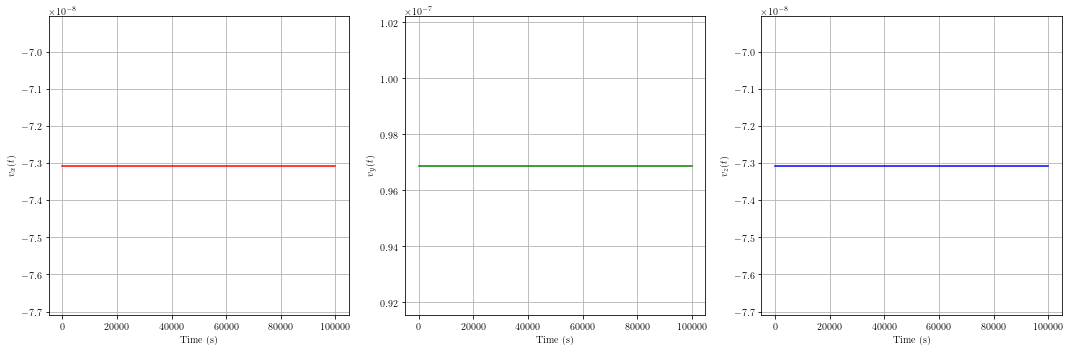

In [7]:


def eta_from_t(t, e, r):
    Omega_k_val = Omega_k(r).value
    # The equation relating eta to t
    def f(eta):
        return Omega_k_val * t - (eta + e * np.sin(eta)) * (1 + e)**(-1.5)
    return newton(f, 0)

def v_x(r, theta, phi, e):
    return -r * Omega_k(r) * (np.sin(theta) * np.cos(phi) + e * np.sin(phi)) / np.sqrt(1 - e)

def v_y(r, theta, phi, e):
    return -r * Omega_k(r) * (np.sin(theta) * np.sin(phi) - e * np.cos(phi)) / np.sqrt(1 - e)

def v_z(r, theta, e):
    return -np.sign(r) * r * Omega_k(r) * np.cos(theta) / np.sqrt(1 - e)

# Given initial conditions
r_initial = 1e8 * u.cm
theta_initial = np.pi / 4
phi_initial = 0  # Example initial condition for phi
e_value = eccentricity(r_initial, theta_initial).value  # No units

# Define the range of times for which to calculate velocities
times = np.linspace(0, 1e5, 500)  # Example: from 0 to 100,000 seconds in 500 steps

# Determine the velocities
vx_vals, vy_vals, vz_vals = [], [], []
for t in times:
    vx = v_x(r_initial, theta_initial, phi_initial, e_value).value
    vy = v_y(r_initial, theta_initial, phi_initial, e_value).value
    vz = v_z(r_initial, theta_initial, e_value).value

    vx_vals.append(vx)
    vy_vals.append(vy)
    vz_vals.append(vz)

# Plotting
plt.figure(figsize=(15, 5))

# v_x(t)
plt.subplot(1, 3, 1)
plt.plot(times, vx_vals, label="v_x(t)", color="r")
plt.yscale("linear")
plt.xlabel("Time (s)")
plt.ylabel(r"$v_x(t)$")
plt.grid(True)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

# v_y(t)
plt.subplot(1, 3, 2)
plt.plot(times, vy_vals, color='g', label="v_y(t)")
plt.yscale("linear")
plt.xlabel("Time (s)")
plt.ylabel(r"$v_y(t)$")
plt.grid(True)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

# v_z(t)
plt.subplot(1, 3, 3)
plt.plot(times, vz_vals, color='b', label="v_z(t)")
plt.yscale("linear")
plt.xlabel("Time (s)")
plt.ylabel(r"$v_z(t)$")
plt.grid(True)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.tight_layout()
plt.show()



# $t_{eq}$

 $t_{eq}$ represents the time at which a particle falls and intersects the equatorial plane.

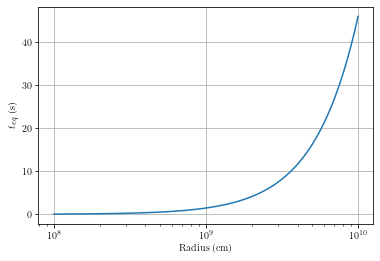

In [8]:

M = 16 * u.M_sun
R = 1e10 * u.cm
#R = (3 * M / (4 * np.pi * 1.4 * u.g/u.cm**3))**(1/3) # rough estimate of the radius based on mean density
Omega = 2 * np.pi * u.rad/u.s # Ansatz angular velocity
theta = np.pi / 2 # equatorial value

# Define Omega_k
def Omega_k(r):
    return np.sqrt(G * M / r**3)


def Omega(r, theta):
    # Ansatz function;
    return 0.5 * Omega_k(r) * np.cos(theta)

# Define t_eq
def t_eq(r):
    omega_k = Omega_k(r)
    term1 = (1 / omega_k).to(u.s) #Remember this is the t_s (sound travel time) related with t_s~(1/Omega_k)
    factor = (1 + 3/4 * (Omega(r, theta) * np.sin(theta) / omega_k)**2)
    term2 = (np.pi / (2**(3/2) * omega_k) * factor).to(u.s)

    return term1 + term2


# Generate radii values
radii = np.linspace(0.01 * R.value, R.value, 500) * u.cm

# Calculate t_eq values
teq_values = [t_eq(r).value for r in radii] # extract the values for plotting

# Plot
plt.semilogx(radii, teq_values)
plt.xlabel('Radius (cm)')
plt.ylabel('$t_{eq}$ (s)')
#plt.title(r'$t_{eq}$')
plt.grid(True)
plt.show()
#print(R, Omega)



# $H_t$

In order to compute the derivatives we will use the finite central difference method

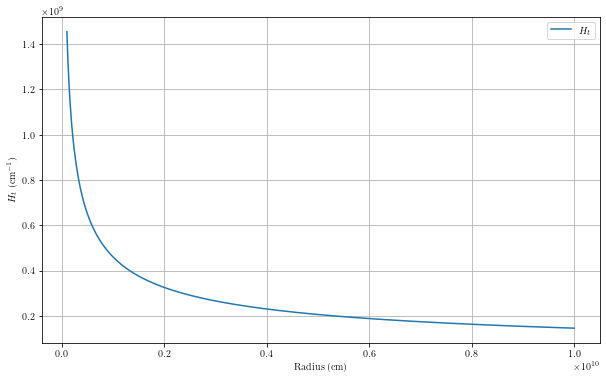

In [9]:
# Small differential to compute the derivative
delta_r = 1e5 * u.cm

# Compute function inside the logarithm
def function_inside_ln(r):
    omega_k_val = Omega_k(r)
    return (1 / omega_k_val + np.pi * 2**-1.5 / omega_k_val).to(u.s).value

# Compute the derivative using central differences
def derivative_central_differences(r):
    upper = function_inside_ln(r + delta_r)
    lower = function_inside_ln(r - delta_r)
    return (upper - lower) / (2 * delta_r.value)

# Compute H_t
def H_t(r):
    return np.abs(1 / derivative_central_differences(r))

#def H_t(r):
#    return u.Quantity(np.abs(1 / derivative_central_differences(r)), 1/u.cm)

# Generate radii values for plotting
radii = np.linspace(0.01 * R.value, R.value, 500) * u.cm
Ht_values = [H_t(r) for r in radii]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(radii, Ht_values, label=r"$H_t$")
plt.xlabel("Radius (cm)")
plt.ylabel(r"$H_t$ (cm$^{-1}$)")
plt.grid(True)
plt.legend()
plt.show()



# $\delta_r$
Radial difference between particles starting at the pole and the equator when they collapse and meet the equatorial plane at the same time $t_{\rm eq}$.


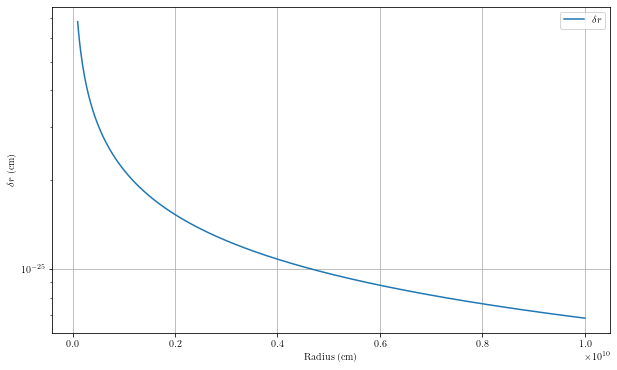

In [10]:
#  delta r
def delta_r_function(r):
    return (H_t(r) / 2) * (Omega(r, np.pi/2) / Omega_k(r))**2

# Compute delta r values for the given radii
delta_r_values = [delta_r_function(r) for r in radii]

# Plotting
plt.figure(figsize=(10, 6))
plt.semilogy(radii, delta_r_values, label=r"$\delta r$")
plt.xlabel("Radius (cm)")
plt.ylabel(r"$\delta r$ (cm)")
plt.grid(True)
plt.legend()
plt.show()


# $\dot M_{\rm fb}(t)$ for a constant density of $\rho=1.4$ $\rm g\ cm$$^{-3}$

Mass Fall-Back rate

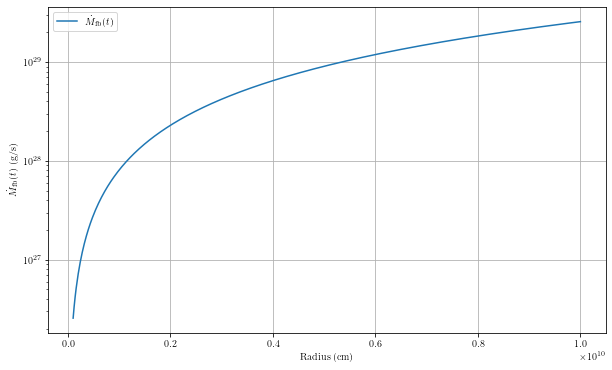

In [11]:
# Given density value
rho = 1.4 * u.g/u.cm**3 #Average density of the Sun, rho=M_sun/(R_sun)^3

# Calculating the derivative of ln(Omega_k) with respect to r
def dln_Omega_k_dr(r):
    upper = np.log(Omega_k(r + delta_r).value)
    lower = np.log(Omega_k(r - delta_r).value)
    return (upper - lower) / (2 * delta_r.value)

# Computing M_dot_fb
def M_dot_fb(r):
    term1 = 4 * np.pi * r**2 * rho
    term2 = 1 / (t_eq(r) * np.abs(dln_Omega_k_dr(r)))  # This should be adjusted once we fix the derivative
    return (term1 * term2)  #


# Computing M_dot_fb values for the given radii
M_dot_fb_values = [M_dot_fb(r).value for r in radii]

# Plotting
plt.figure(figsize=(10, 6))
plt.semilogy(radii, M_dot_fb_values, label=r"$\dot M_{\rm fb}(t)$")
plt.xlabel("Radius (cm)")
plt.ylabel(r"$\dot M_{\rm fb}(t)$ (g/s)")
plt.grid(True)
plt.legend()
plt.show()





# Importing a .CSV file that fits $\log(\rho)$ vs $M(r)$

I have used WebPlotDigitizer website in order to extract the data for the built-in figures in the PDF

In [12]:
import pandas as pd
from scipy.interpolate import interp1d

# Loading the CSV data
data_rhoM = pd.read_csv('./Data/log_rho_vs_M_r.csv',header=None,sep=";",decimal=",")
#This data were obtained from Figure 2a of Kumar+2018

M_r_values = data_rhoM[0].values*u.M_sun
log_density_values = data_rhoM[1].values
density_values = 10**log_density_values * u.g/u.cm**3  # Convert log density to actual density



# Building an interpolating function for density as a function of M(r)
density_function_M = interp1d( M_r_values, log_density_values, kind='linear', fill_value="extrapolate")


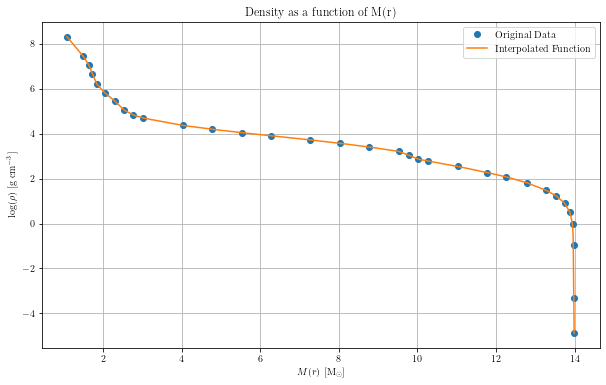

In [13]:
# Defining a range for M_r for plotting purposes
M_r_range = np.linspace(min(M_r_values), max(M_r_values), 1000)

# Evaluating the interpolated density values
interpolated_densities = density_function_M(M_r_range)
log_interpolated_densities = 10**interpolated_densities
plt.figure(figsize=(10, 6))
plt.plot( M_r_values, log_density_values,'o', label='Original Data')
plt.plot( M_r_range, interpolated_densities, '-', label='Interpolated Function')
plt.xlabel(r'$M(r)$ [M$_\odot$]')
plt.ylabel(r'$\log(\rho)$ [g cm$^{-3}$]')
plt.legend()
plt.title('Density as a function of M(r)')
plt.grid(True)
plt.show()

# Importing a .CSV file that fits $\log(\rho)$ vs $r$

This correspond to Figure 2b of Kumar+2018

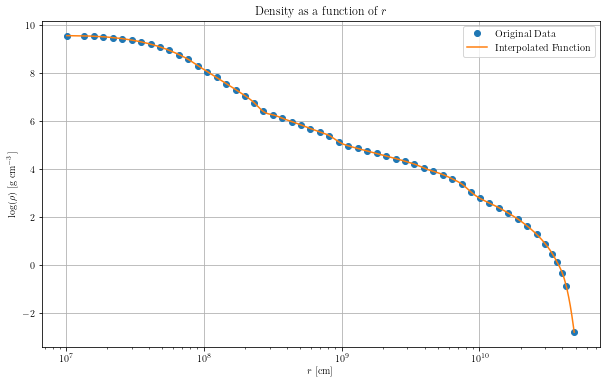

In [14]:
# Loading the CSV data
data_rhoR = pd.read_csv('./Data/log_rho_vs_r.csv',header=None,sep=";",decimal=",")

radius_values = data_rhoR[0].values * u.cm
log_density_values_r = data_rhoR[1].values
density_values_r = 10**log_density_values_r * u.g/u.cm**3  # Convert log density to actual density



# Building an interpolating function for density as a function of M(r)
density_function_r = interp1d( radius_values, log_density_values_r, kind='cubic', fill_value="extrapolate")

# Defining a range for radius for plotting purposes
radius_range = np.linspace(min(radius_values), max(radius_values), 10000)

# Evaluating the interpolated density values
interpolated_densities = density_function_r(radius_range)
log_interpolated_densities = 10**interpolated_densities
plt.figure(figsize=(10, 6))
plt.semilogx( radius_values, log_density_values_r,'o', label='Original Data')
plt.semilogx( radius_range, interpolated_densities, '-', label='Interpolated Function')
plt.xlabel(r'$r$ [$\rm cm$]')
plt.ylabel(r'$\log(\rho)$ [g cm$^{-3}$]')
plt.legend()
plt.title('Density as a function of $r$')
plt.grid(True)
plt.show()



# Calculation of $\dot{M}(r)$ with the Kumar's density profile

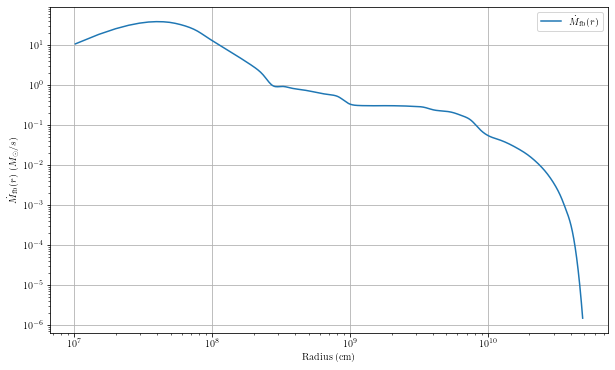

In [15]:
# Using the interpolated density function to get the density for a given radius
def rho_interpolated(r):
    log_density = density_function_r(r)
    return 10**log_density

# Updating the M_dot_fb function to use the interpolated density
def M_dot_fb(r):
    term1 = 4 * np.pi * r**2 * rho_interpolated(r)
    term2 = 1 / (t_eq(r) * np.abs(dln_Omega_k_dr(r)))
    return (term1 * term2)

# Computing M_dot_fb values for the given radii
M_dot_fb_values = [M_dot_fb(r).value for r in radius_range]

# Converting the results from g/s to M_sun/s
M_dot_fb_values_solar = [val / M_sun.to(u.g).value for val in M_dot_fb_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.loglog(radius_range, M_dot_fb_values_solar, label=r"$\dot M_{\rm fb}(r)$")
plt.xlabel("Radius (cm)")
plt.ylabel(r"$\dot M_{\rm fb}(r)$ ($M_{\odot}/s$)")
plt.grid(True)
plt.legend()
plt.show()


# Polishing the previous plot

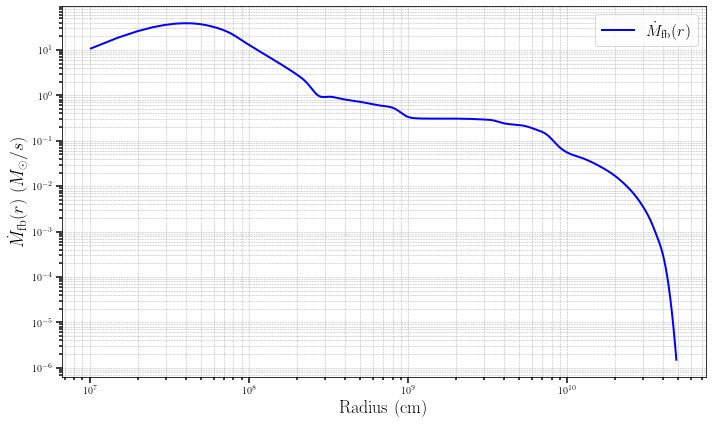

In [16]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(radius_range, M_dot_fb_values_solar, label=r"$\dot M_{\rm fb}(r)$", color='blue', linewidth=2)

# Setting axis labels
ax.set_xlabel("Radius (cm)", fontsize=18)
ax.set_ylabel(r"$\dot M_{\rm fb}(r)$ ($M_{\odot}/s$)", fontsize=18)

# Setting the grid and tweaking the looks
ax.grid(True, which="both", ls="--", linewidth=0.5)
ax.tick_params(axis='both', which='major', width=1.5, length=6)
ax.tick_params(axis='both', which='minor', width=1.5, length=3)

# Legend
ax.legend(fontsize=16, loc='best')

plt.tight_layout()
plt.show()


# Importing a .CSV file containing $\Omega$ vs $r$

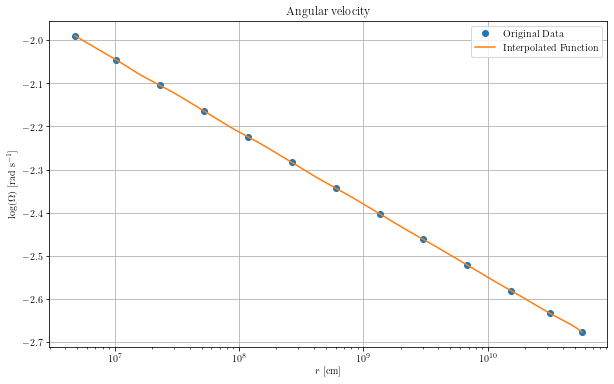

In [17]:
# Loading the CSV data
data_Omega = pd.read_csv('./Data/log_Omega_vs_r.csv',header=None,sep=";",decimal=",")

radius_values_Omega = data_Omega[0].values * u.cm
log_Omega = data_Omega[1].values
Omega_r = 10**log_Omega * u.rad/u.s  # Convert log Omega to actual angular velocity



# Building an interpolating function for density as a function of M(r)
Omega = interp1d( radius_values_Omega, log_Omega, kind='cubic', fill_value="extrapolate")

# Defining a range for radius for plotting purposes
radius_range_Omega = np.linspace(min(radius_values_Omega), max(radius_values_Omega), 10000)

# Evaluating the interpolated density values
interpolated_Omega = Omega(radius_range_Omega)
log_interpolated_Omega = 10**interpolated_Omega
plt.figure(figsize=(10, 6))
plt.semilogx( radius_values_Omega, log_Omega,'o', label='Original Data')
plt.semilogx( radius_range_Omega, interpolated_Omega, '-', label='Interpolated Function')
plt.xlabel(r'$r$ [$\rm cm$]')
plt.ylabel(r'$\log(\Omega)$ [rad s$^{-1}$]')
plt.legend()
plt.title('Angular velocity')
plt.grid(True)
plt.show()

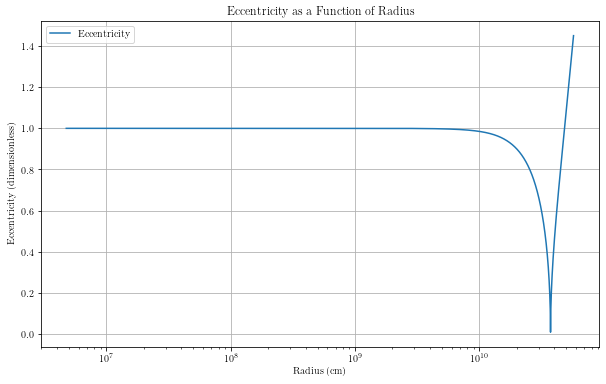

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import astropy.units as u

# Constants
G = 6.67430e-8  # Gravitational constant in cgs units
M = 1.989e33  # Solar mass in g
theta = np.pi / 4  # Example value for theta (you can adjust)

# Loading the CSV data
data_Omega = pd.read_csv('./Data/log_Omega_vs_r.csv', header=None, sep=";", decimal=",")
radius_values_Omega = data_Omega[0].values
log_Omega = data_Omega[1].values

# Building an interpolation function for Omega as a function of radius
Omega_interpolated = interp1d(radius_values_Omega, 10**log_Omega, kind='cubic', fill_value="extrapolate", bounds_error=False)

# Define a range of radii for interpolation
min_radius = min(radius_values_Omega)
max_radius = max(radius_values_Omega)
num_points = 10000
radius_range_Omega = np.linspace(min_radius, max_radius, num_points)

# Interpolate Omega values in rad/s units
interpolated_Omega_rad_per_s = Omega_interpolated(radius_range_Omega)

# Keplerian angular velocity (dimensionless)
def Omega_k(r):
    return np.sqrt(G * M / r**3)

# Define a function for eccentricity
def eccentricity(r):
    omega_val = Omega_interpolated(r)
    omega_k_val = Omega_k(r)
    omega_ratio = (omega_val * np.sin(theta)) / omega_k_val
    e_squared = 1 - omega_ratio**2
    return np.sqrt(np.abs(e_squared))

# Compute eccentricity for each r in the radius range
e_values = [eccentricity(r) for r in radius_range_Omega]

# Plotting eccentricity as a function of radius with units
plt.figure(figsize=(10, 6))
plt.semilogx(radius_range_Omega, e_values, label='Eccentricity')
plt.xlabel('Radius (cm)')
plt.ylabel('Eccentricity (dimensionless)')
plt.title('Eccentricity as a Function of Radius')
plt.grid(True)
plt.legend()
plt.show()

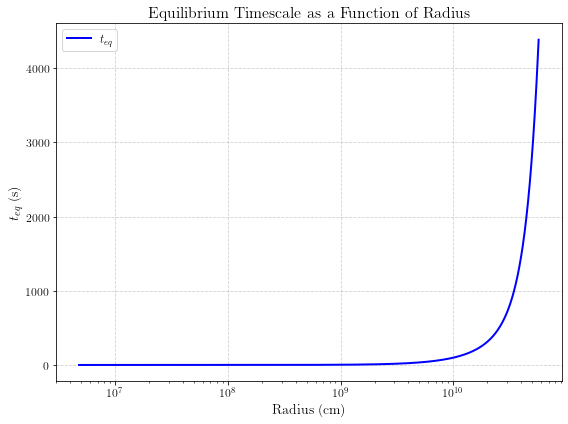

In [19]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

# Constants in cgs units
G = 6.67430e-8  # Gravitational constant in cm^3/g/s^2
M = 1.989e33    # Solar mass in grams
theta = np.pi / 4  # Example value for theta (you can adjust)

# Loading the CSV data
data_Omega = pd.read_csv('./Data/log_Omega_vs_r.csv', header=None, sep=";", decimal=",")
radius_values_Omega = data_Omega[0].values
log_Omega = data_Omega[1].values

# Building an interpolation function for Omega as a function of radius
Omega_interpolated = interp1d(radius_values_Omega, 10**log_Omega, kind='cubic', fill_value="extrapolate", bounds_error=False)

# Defining a range of radii for interpolation
min_radius = min(radius_values_Omega)
max_radius = max(radius_values_Omega)
num_points = 10000
radius_range_Omega = np.linspace(min_radius, max_radius, num_points)

# Interpolating Omega values in rad/s units
interpolated_Omega_rad_per_s = Omega_interpolated(radius_range_Omega)

# Keplerian angular velocity in rad/s
def Omega_k(r):
    return np.sqrt(G * M / r**3)

# Defining a function for t_eq in seconds
def t_eq(r):
    omega_val = Omega_interpolated(r)
    omega_k_val = Omega_k(r)
    omega_ratio = (omega_val * np.sin(theta)) / omega_k_val
    factor = 1 + (3/4) * omega_ratio**2
    return np.pi / (2**(3/2) * omega_k_val) * factor

# Compute t_eq for each r in the radius range (in seconds)
t_eq_values = [t_eq(r) for r in radius_range_Omega]

# Plot
plt.figure(figsize=(8, 6))
plt.semilogx(radius_range_Omega, t_eq_values, label='$t_{eq}$', linewidth=2, color='b')
plt.xlabel('Radius (cm)', fontsize=14)
plt.ylabel('$t_{eq}$ (s)', fontsize=14)
plt.title('Equilibrium Timescale as a Function of Radius', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tick_params(labelsize=12)
plt.tight_layout()


#plt.savefig('equilibrium_timescale.pdf', dpi=300)
plt.show()  



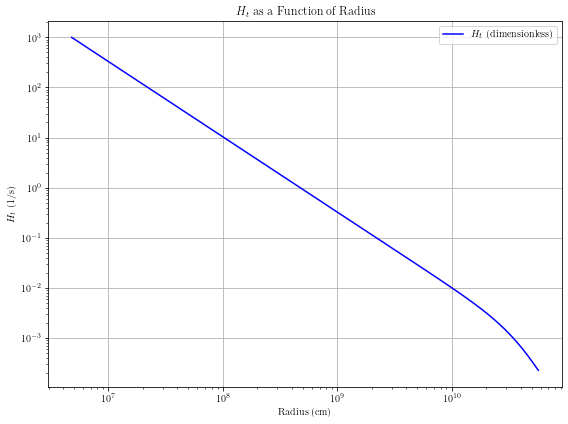

In [20]:
def H_t(r):
    t_eq_val = t_eq(r)
    return 1 / t_eq_val

# Compute H_t for each r in the radius range (1/s)
H_t_values = [H_t(r) for r in radius_range_Omega]

# Create the high-quality plot
plt.figure(figsize=(8, 6))
plt.loglog(radius_range_Omega, H_t_values, label='$H_t$ (dimensionless)', color='blue')
plt.xlabel('Radius (cm)')
plt.ylabel('$H_t$ (1/s)')
plt.title('$H_t$ as a Function of Radius')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save the plot as a high-quality image
#plt.savefig('H_t_plot.png', dpi=300)

# Show the plot
plt.show()

# Plotting $\dot{M}_{\rm fb}$ as a function of the radius and $t_{\rm eq}$

## We have used the analytycal form for the ${\frac{d\ln\Omega_k}{dr}}$

## ${\frac{d\ln\Omega_k}{dr}}=-\frac{3}{2} \frac{GM_r}{r^4}\Omega_k^{-1}$

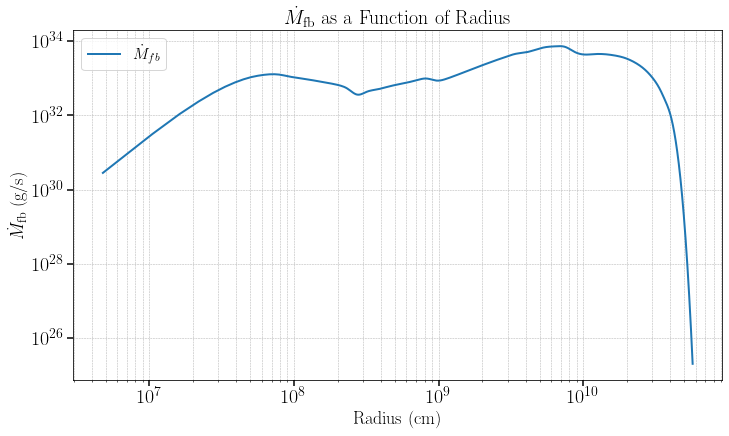

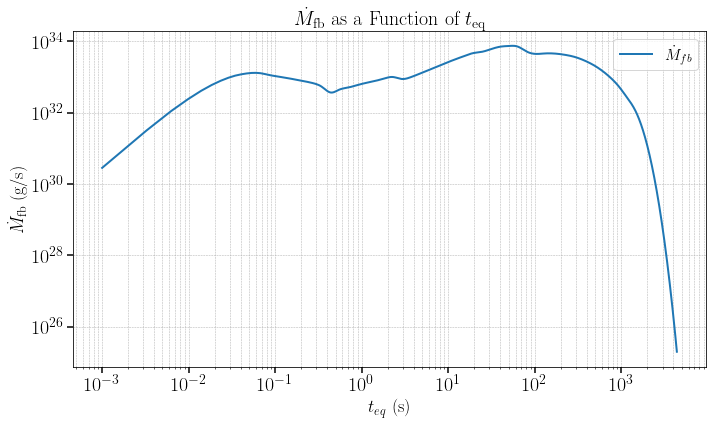

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Using the Keplerian angular velocity formula
def dln_Omega_k_dr(r):
    Omega_k_val = Omega_k(r)
    return -1.5 * G * M / r**4 / Omega_k_val

# Compute M_dot_fb for each r in the radius range
M_dot_fb_values = [M_dot_fb(r) for r in radius_range_Omega]

# Plot M_dot_fb as a function of radius
plt.figure(figsize=(10, 6))
plt.loglog(radius_range_Omega, M_dot_fb_values, label=r'$\dot{M}_{fb}$', linewidth=2)
plt.xlabel('Radius (cm)', fontsize=18)
plt.ylabel(r'$\dot{M}_{\rm fb}$ (g/s)', fontsize=18)
plt.title(r'$\dot{M}_{\rm fb}$ as a Function of Radius', fontsize=20)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend(fontsize=16)
plt.tight_layout()
plt.tick_params(axis='both', labelsize=20, width=1.5, length=6)
plt.show()

# Plot M_dot_fb as a function of t_eq
plt.figure(figsize=(10, 6))
plt.loglog(t_eq_values, M_dot_fb_values, label=r'$\dot{M}_{fb}$', linewidth=2)
plt.xlabel(r'$t_{eq}$ (s)', fontsize=18)
plt.ylabel(r'$\dot{M}_{\rm fb}$ (g/s)', fontsize=18)
plt.title(r'$\dot{M}_{\rm fb}$ as a Function of $t_{\rm eq}$', fontsize=20)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend(fontsize=16)
plt.tick_params(axis='both', labelsize=20, width=1.5, length=6)
plt.tight_layout()
plt.show()

# Plotting $\dot{M}_{\rm fb}$ as a function of the radius and $t_{\rm eq}$

## We have obtained the derivative by numerical methods

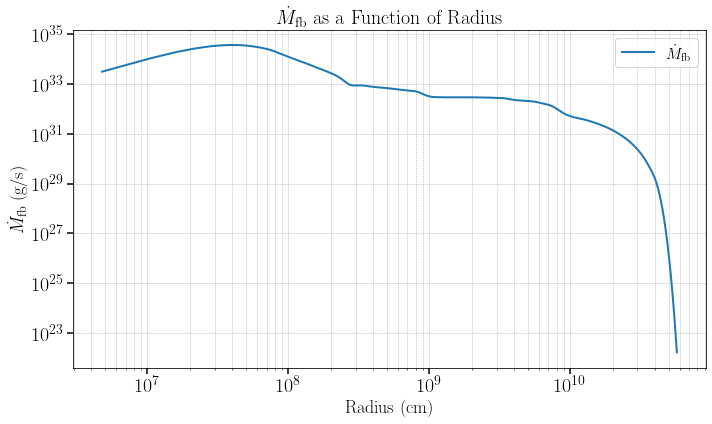

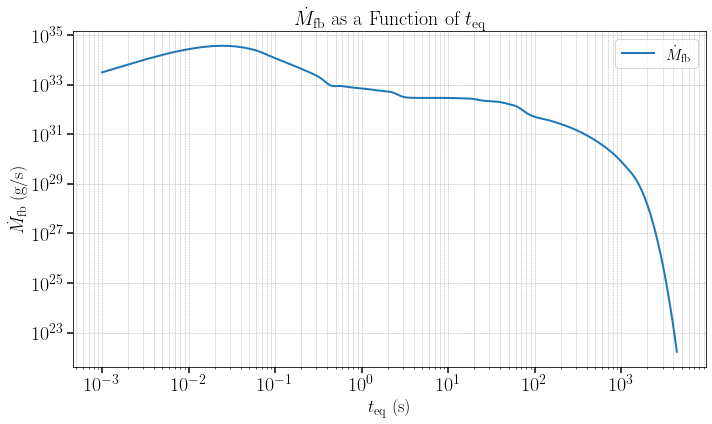

In [32]:
import numpy as np
import matplotlib.pyplot as plt

delta_r = 1e5 

def dln_Omega_k_dr(r):
    upper = np.log(Omega_k(r + delta_r))
    lower = np.log(Omega_k(r - delta_r))
    return (upper - lower) / (2 * delta_r)

# Compute M_dot_fb for each r in the radius range
M_dot_fb_values = [M_dot_fb(r) for r in radius_range_Omega]

# Plot M_dot_fb as a function of radius
plt.figure(figsize=(10, 6))
plt.loglog(radius_range_Omega, M_dot_fb_values, label=r'$\dot{M}_{\rm fb}$', linewidth=2)
plt.xlabel('Radius (cm)', fontsize=18)
plt.ylabel(r'$\dot{M}_{\rm fb}$ (g/s)', fontsize=18)
plt.title(r'$\dot{M}_{\rm fb}$ as a Function of Radius', fontsize=20)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend(fontsize=16)
plt.tick_params(axis='both', labelsize=20, width=1.5, length=6)
plt.tight_layout()
plt.show()

# Plot M_dot_fb as a function of t_eq
plt.figure(figsize=(10, 6))
plt.loglog(t_eq_values, M_dot_fb_values, label=r'$\dot{M}_{\rm fb}$', linewidth=2)
plt.xlabel(r'$t_{\rm eq}$ (s)', fontsize=18)
plt.ylabel(r'$\dot{M}_{\rm fb}$ (g/s)', fontsize=18)
plt.title(r'$\dot{M}_{\rm fb}$ as a Function of $t_{\rm eq}$', fontsize=20)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend(fontsize=16)
plt.tick_params(axis='both', labelsize=20, width=1.5, length=6)
plt.tight_layout()
plt.show()